第9回の演習です。平行ステレオを構築します。
左上の「ファイル」＞「ドライブにコピーを保存」を選択して、Google DriveにNotebookを保存します。ご自身のGoogleドライブの"Colab Notebooks"フォルダで、保存したNotebookを右クリックし、「アプリで開く」＞「Google Colaboratory」を選択します。その上で、各コードを実行するには、以下のコマンドを実行してください。実行は「再生」ボタンを押します。

In [ ]:
print("Chapter 9")

Chapter 9


# 平行ステレオ
ステレオ画像から奥行き分布を導出します。ここでは、以下の2つの手法を試してみます。
- Block Matching Method
- Semi-Global Block Matching Method

ステレオ画像対は以下のWebサイトからダウンロードできます。
- [Middlebury Stereo Datasets](https://vision.middlebury.edu/stereo/data/)

ここで示すTsukubaステレオ画像対は以下に置きましたので、必要な方はこちらからダウンロードして下さい。
- [stereo_left.png](https://drive.google.com/file/d/1v4kN_2Zkgdmy5TgW3v4l5G5bjqB41AJr/view?usp=sharing)
- [stereo_right.png](https://drive.google.com/file/d/1SI-6nnoTH55O2fsDsPGB7LENk_blnut_/view?usp=sharing)

In [ ]:
# ファイルのアップロード
from google.colab import files
uploaded1 = files.upload()
uploaded2 = files.upload()
# 画像のファイル名を取得
image_filenames1 = list(uploaded1.keys())           # 辞書型をリスト型に変換
image_filenames2 = list(uploaded2.keys())           # 辞書型をリスト型に変換
image_filename1 = image_filenames1[0]               # リストの最初の要素（行）を取り出す
image_filename2 = image_filenames2[0]               # リストの最初の要素（行）を取り出す
print("ファイル名：", image_filename1, image_filename2)

Saving stereo_left.png to stereo_left.png


Saving stereo_right.png to stereo_right.png
ファイル名： stereo_left.png stereo_right.png


画像をグレースケールで読み込みます。

4.8.0


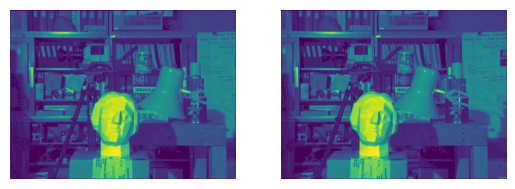

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
print(cv2.__version__)

# グレースケール画像として読み込む（imreadの第2引数：cv2.IMREAD_GRAYSCALE）
imgL = cv2.imread(image_filename1, cv2.IMREAD_GRAYSCALE)
imgR = cv2.imread(image_filename2, cv2.IMREAD_GRAYSCALE)

# 新規ウィンドウ作成
fig = plt.figure()
# fig全体を縦と横に分割する
X = 1
Y = 2

# img1の表示
img1plot = 1
ax1 = fig.add_subplot(X, Y, img1plot)
ax1.axis('off')
plt.imshow(imgL)

# img2の表示
img2plot = 2
ax2 = fig.add_subplot(X, Y, img2plot)
ax2.axis('off')
plt.imshow(imgR)

# plt.xticks([]), plt.yticks([])  # x軸とy軸のメモリを隠す
plt.show()

## ブロックマッチング法
ステレオ画像から奥行分布を導出する関数としてStereoBM_createがあります。引数にはnumDisparitiesとblockSizeとがあります。numDisparitiesは奥行値を推定するとき、ステレオ画像をずらす画素数を指定します。このnumDisparitiesよりも大きいズレ幅があると、ステレオ対応がうまく導出されません。numDisparitiesに大きな値を指定すると、手前の物体まで奥行き値を推定します。もう一つの引数blockSizeはブロックの大きさを指定します。blockSizeに小さい値を指定すると細かい領域の奥行き値を求め、大きい値にするとまとまった領域の奥行き値を求めます。

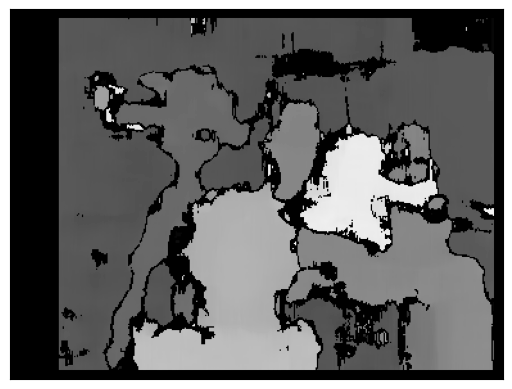

In [ ]:
# Block Matching Method

stereo = cv2.StereoBM_create(numDisparities=32, blockSize=15)
disparity = stereo.compute(imgL,imgR)

plt.imshow(disparity,'gray')
plt.xticks([]), plt.yticks([])  # x軸とy軸のメモリを隠す
plt.show()

## セミグローバル・ブロックマッチング法
視差を導出する際にコスト関数を設定し、最適な視差を求めるプロセスを導入しています。

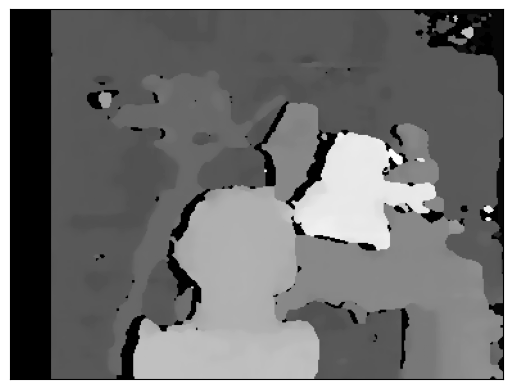

In [ ]:
# Semi-Global Block Matching Method

# disparity range is tuned for 'aloe' image pair
window_size = 3
min_disp = 0
num_disp = 32 - min_disp
stereo = cv2.StereoSGBM_create(
    minDisparity = min_disp,            # 視差の最小値
    numDisparities = num_disp,          # 視差の範囲
    blockSize = 11,                     # ブロックサイズ
    P1 = 8*3*window_size**2,            # 視差の滑らかさを制御
    P2 = 32*3*window_size**2,           # 視差の滑らかさを制御
    disp12MaxDiff = 1,                  # 左と右との視差を確認する際に許容される最大の差
    uniquenessRatio = 10,               # 導出された視差が最も適正であると判断するための2番目によい値とのマージン
    speckleWindowSize = 100,            # 滑らかな視差領域の最大サイズ
    speckleRange = 32                   # 連結成分における視差変動の最大値
)
disparity = stereo.compute(imgL,imgR)

plt.imshow(disparity,'gray')
plt.xticks([]), plt.yticks([])  # x軸とy軸のメモリを隠す
plt.show()

# カメラキャリブレーション
上に示したステレオ画像から奥行分布を導出するには、カメラの内部パラメータがわかっていないといけません。そこで、カメラパラメータとレンズひずみを求めます。まず、以下からチェッカーパターンを複数の視点から撮影したカメラ画像をダウンロードします。

ご自身のカメラのカメラパラメータを導出したいなら、そのカメラでチェッカーパターンを撮影し、そのカメラ画像のファイルをアップロードします。カメラキャリブレーションに使うチェッカーパターンはOpenCVのWebサイトで提供されています。以下からダウンロードして下さい（[チェッカーパターン](http://opencv.jp/sample/pics/chesspattern_7x10.pdf)）。

## カメラ画像の準備
カメラでチェッカーパターンを撮影した画像を幾つか用意します。本来は使用するカメラで撮った画像じゃないと意味がないのですが、ここではプログラムの動作を確認するために、一連の画像ファイルを以下のGitHubのWebサイトから取得して下さい。
- [image files](https://github.com/opencv/opencv/tree/master/samples/data)

ダウンロードするのは、left01.jpg, left02.jpg, ..., left14.jpgという一連の画像ファイルです。ダウンロードしたファイルを、今度はご自身のGoogle Colaboratoryにアップロードします。左側のサイドバーで「フォルダ」アイコンをクリックし、そこに一連の画像ファイルをドラッグ＆ドロップして下さい。

globモジュールについて簡単に説明しておきます。globモジュールのglob関数は、条件に一致するファイルを取得するものです。ファイルの一致条件を引数として与えると、その条件に一致したファイルを返してくれます。

4.8.0
['left07.jpg', 'left05.jpg', 'left06.jpg', 'left04.jpg', 'left03.jpg', 'left14.jpg', 'left09.jpg', 'left12.jpg', 'left13.jpg', 'left02.jpg', 'left08.jpg', 'left01.jpg', 'left11.jpg']


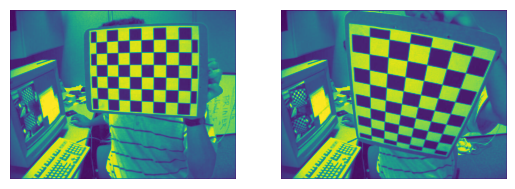

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import glob
print(cv2.__version__)

images = glob.glob('*.jpg')
print(images)

# グレースケール画像として読み込む（imreadの第2引数：cv2.IMREAD_GRAYSCALE）
img01 = cv2.imread('left01.jpg', cv2.IMREAD_GRAYSCALE)
img02 = cv2.imread('left02.jpg', cv2.IMREAD_GRAYSCALE)

# 新規ウィンドウ作成
fig = plt.figure()
# fig全体を縦と横に分割する
X = 1
Y = 2

# img1の表示
img1plot = 1
ax1 = fig.add_subplot(X, Y, img1plot)
ax1.axis('off')
plt.imshow(img01)

# img2の表示
img2plot = 2
ax2 = fig.add_subplot(X, Y, img2plot)
ax2.axis('off')
plt.imshow(img02)

# plt.xticks([]), plt.yticks([])  # x軸とy軸の目盛りを隠す
plt.show()

## カメラの内部パラメータの算出
まず、カメラの内部パラメータを算出します。

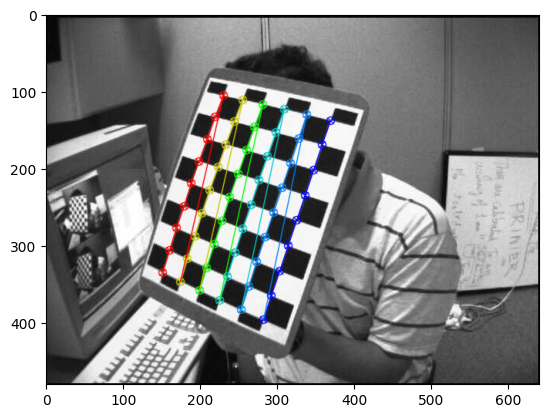

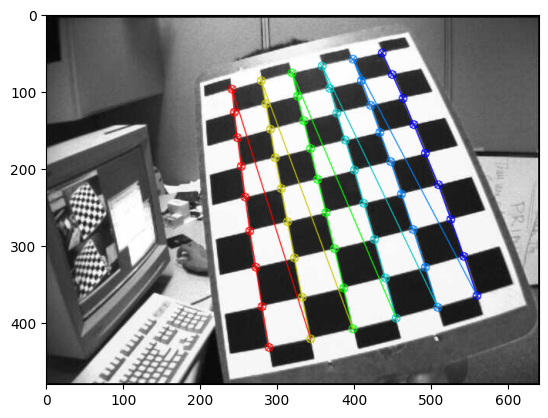

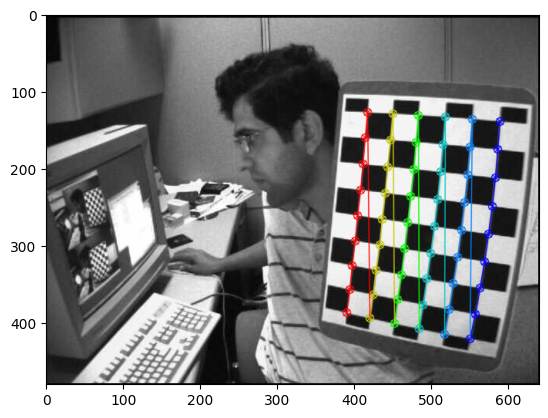

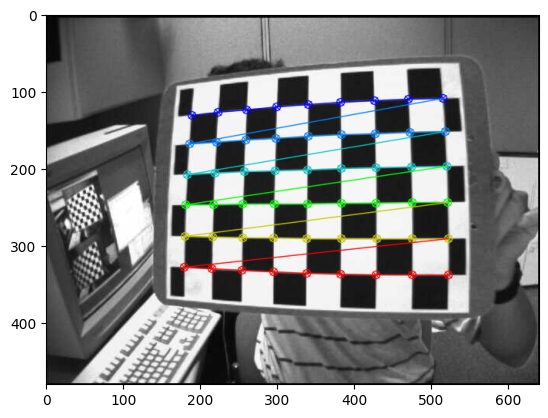

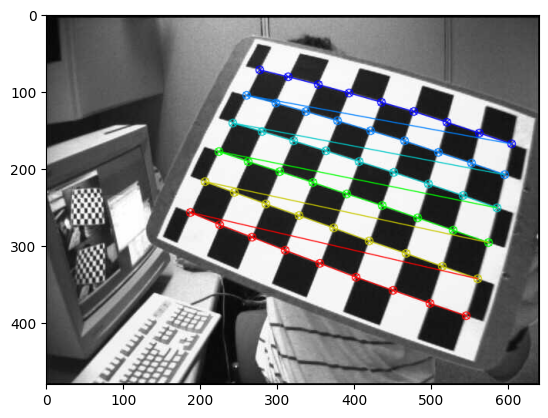

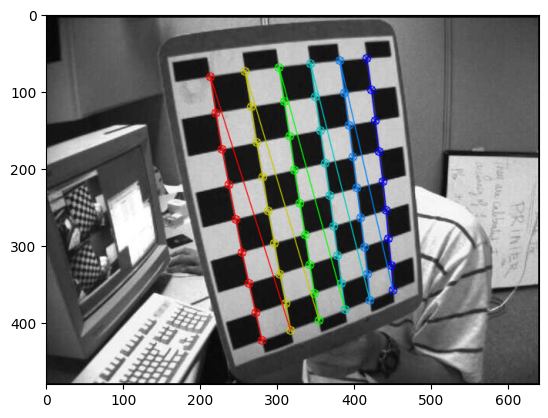

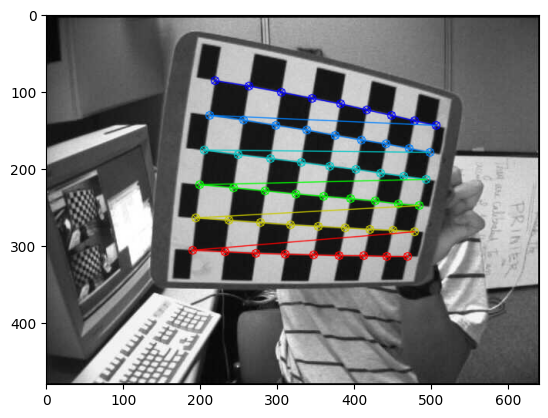

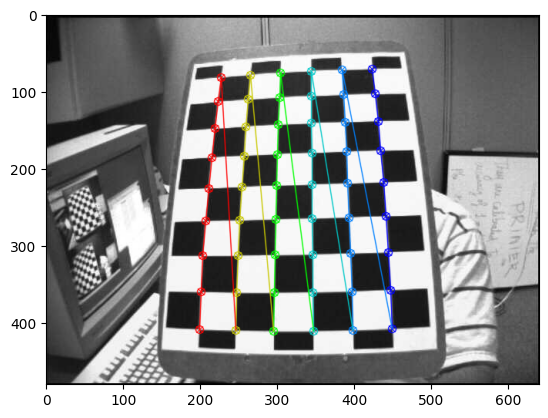

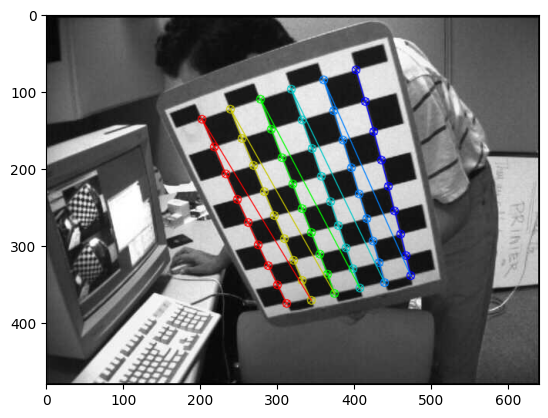

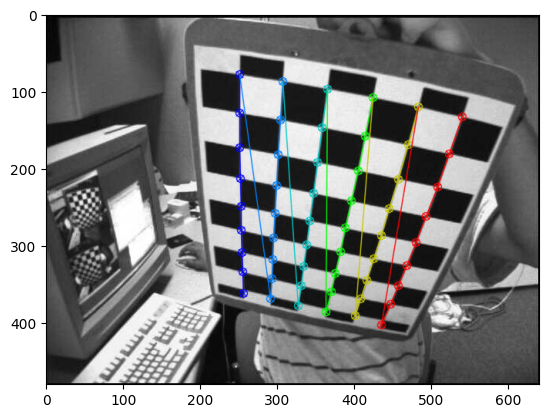

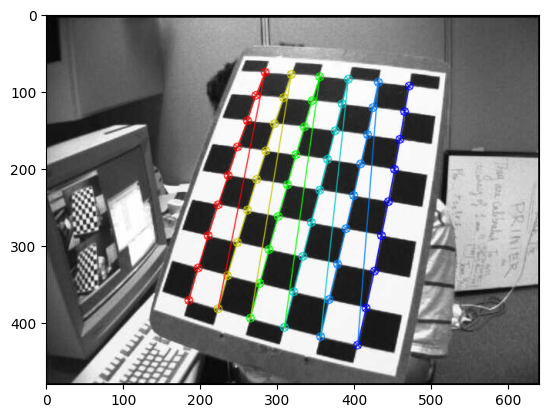

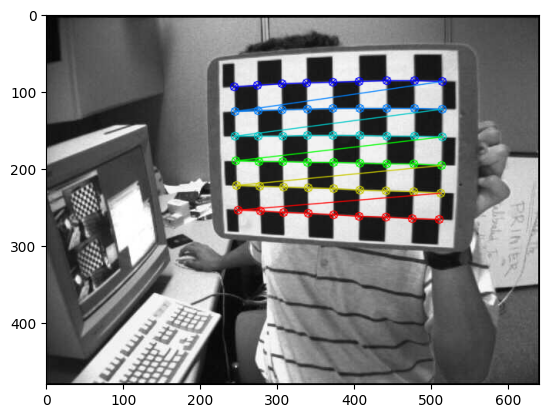

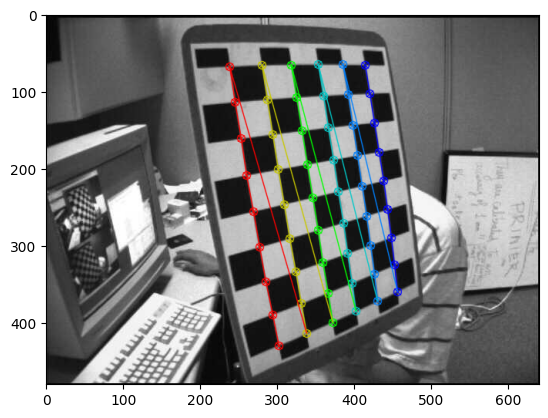

In [ ]:
# カメラの内部パラメータの算出

# コーナーの閾値
# cv2.TERM_CRITERIA_EPS：指定した精度に達したら、繰り返し計算を終了
# cv2.TERM_CRITERIA_MAX_ITER：指定した繰り返し回数に達したら、繰り返し計算を終了
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# チェッカーパターンの3次元座標＠ワールド座標系
# (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# キャリブレーションで利用するチェッカーパターンの座標
objpoints = [] # 3次元点のベクトルを格納（real world space）
imgpoints = [] # 2次元点のベクトルを格納（image plane）

for fname in images:
    # 画像の取得
    img = cv2.imread(fname)

    # グレースケール変換
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # チェッカーパターンのコーナーを検出
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # コーナーが検出されたら、3次元点と2次元点を格納
    if ret == True:
        objpoints.append(objp)

        # 2次元点に対して精度を改善
        corners2 = cv2.cornerSubPix(gray, corners, (11,11), (-1,-1), criteria)
        imgpoints.append(corners2)

        # コーナーを表示
        cv2.drawChessboardCorners(img, (9,6), corners2, ret)
        plt.imshow(img)
        plt.show()


## 内部パラメータの計算
次に内部パラメータを計算します。

In [ ]:
# 画像サイズ
imageSize = gray.shape[::-1]
print(imageSize)
import IPython
# 内部パラメータを計算（rvecs, tvecsは外部パラメータに相当）
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, imageSize, None, None)

# 計算結果を保存
# np.save("mtx", mtx)           # カメラ行列
# np.save("dist", dist.ravel()) # 歪みパラメータ

# 計算結果を表示
print("RMS = ", ret)          # 誤差に相当（小さい値の方がよい）
print("mtx = \n", mtx)
print("dist = ", dist.ravel())

(640, 480)
RMS =  0.4086955848818606
mtx = 
 [[536.07343019   0.         342.37038791]
 [  0.         536.01634475 235.53685635]
 [  0.           0.           1.        ]]
dist =  [-0.26509006 -0.0467439   0.00183301 -0.00031471  0.25231586]


# 内部パラメータを使って画像を補正
次に内部パラメータを使って、画像を補正します。

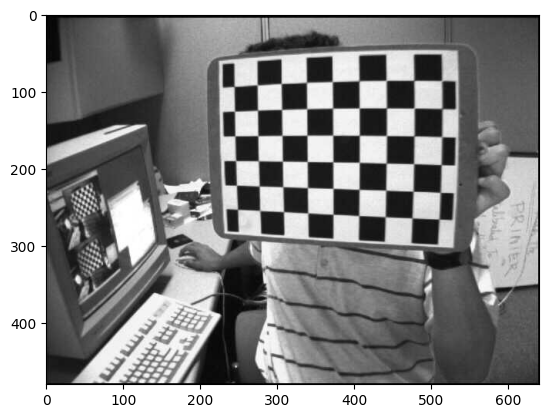

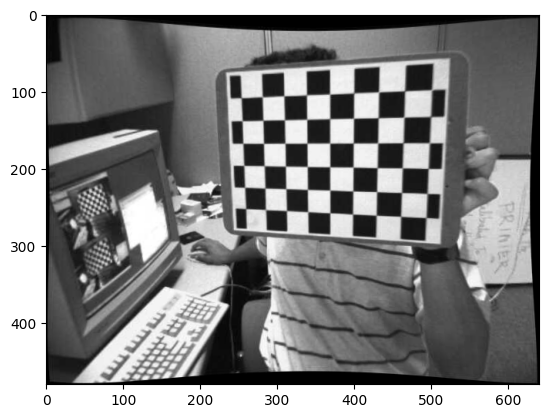

In [ ]:
# 補正したい画像の読み込み
targetImage = cv2.imread('left01.jpg')
targetImageSize = targetImage.shape[:2][::-1]

# ひずみ係数を用いてカメラ行列を計算（補正前と補正後とでは画像のサイズが違う）
alpha = 1           # 補正前にない画素は画素値ゼロ
newcameramtx, roiSize = cv2.getOptimalNewCameraMatrix(mtx, dist, targetImageSize, alpha, targetImageSize)

# 内部パラメータに基づいて画像を補正
undistortedImage = cv2.undistort(targetImage, mtx, dist, None, newcameramtx)

# 画像の表示
plt.imshow(targetImage)
plt.show()
plt.imshow(undistortedImage)
plt.show()